In [1]:
%matplotlib inline
from netCDF4 import Dataset
from pylab import *
import numpy as np
import glob
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from spharm import Spharmt
from tqdm import tqdm

from matplotlib.ticker import AutoMinorLocator

cmap = sns.cubehelix_palette(light=1, as_cmap=True, reverse=True)
cmap = ListedColormap(sns.color_palette("coolwarm", 9).as_hex())
sns.reset_orig()

matplotlib.rcParams['lines.linewidth'] = 0.6

matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['font.size'] = 7
matplotlib.rcParams['legend.frameon'] = False

matplotlib.rcParams['figure.dpi'] = 150
matplotlib.rcParams['axes.facecolor'] = '#F8F8FF'
matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['axes.axisbelow'] = 'line'
matplotlib.rcParams['axes.labelsize'] = 7

matplotlib.rcParams['grid.linestyle'] = '-.'
matplotlib.rcParams['grid.linewidth'] = 0.4

matplotlib.rcParams['xtick.major.size'] = 5
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['xtick.minor.size'] = 3
matplotlib.rcParams['xtick.minor.width'] = 0.7

matplotlib.rcParams['ytick.major.size'] = 5
matplotlib.rcParams['ytick.major.width'] = 1
matplotlib.rcParams['ytick.minor.size'] = 3
matplotlib.rcParams['ytick.minor.width'] = 0.7


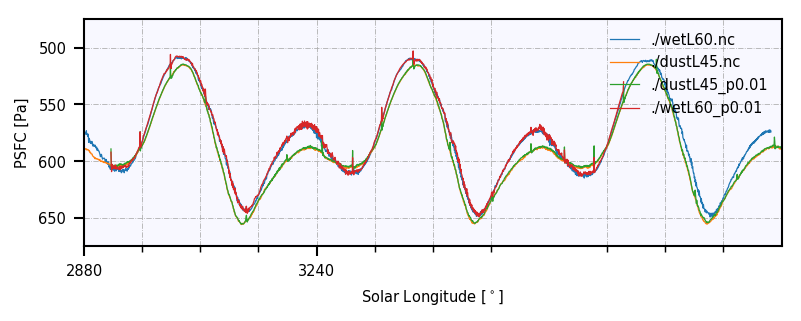

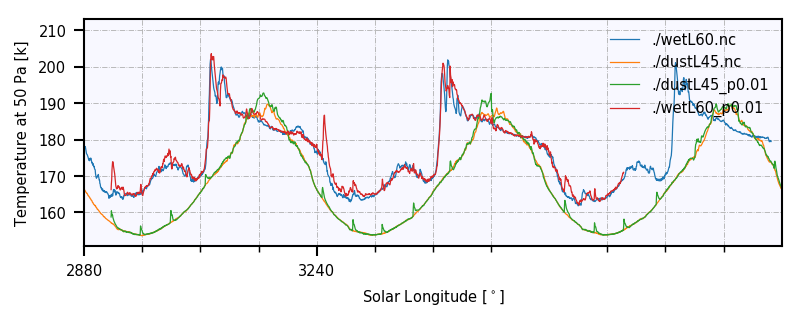

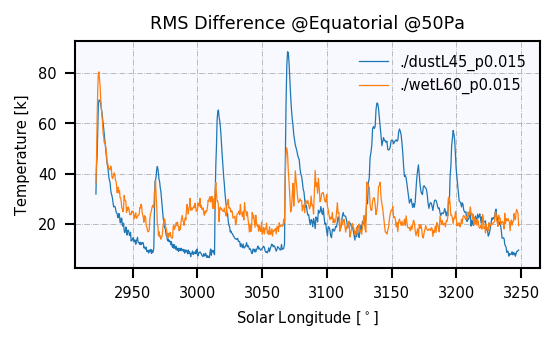

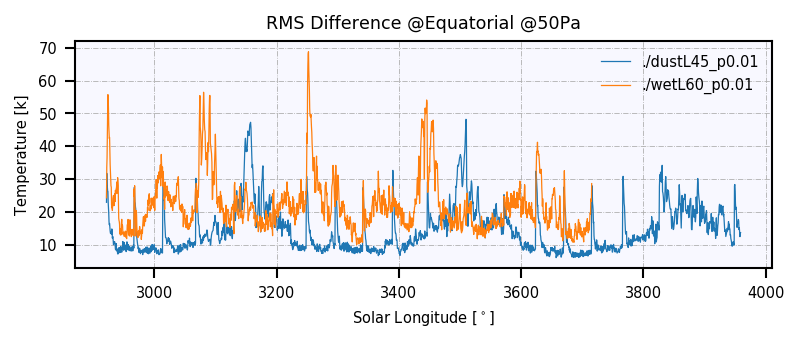

In [2]:
from netCDF4 import Dataset

major_ticks = np.arange(0, 360*10, 360)  

def yearly_ls(ls):
    idx = np.where(ls==360)[0]
    counter = 1
    for i in np.arange(idx.size-1):
        ls[idx[i]:idx[i+1]] += counter*360
        ls[idx[i]] -= 360
        counter += 1
    if idx.size == 1:
        i = 0
        ls[idx[i]:] += counter*360
        ls[idx[i]] -= 360
    else:
        ls[idx[i+1]:] += counter*360
        ls[idx[i+1]] -= 360
    return ls

# wet data
filedir_d = './wetL60.nc'
data = Dataset(filedir_d,'r')
psfcwet = data.variables['PSFC'][:][:,17:20].mean(axis=2).mean(axis=1)
twet = data.variables['T50Pa'][:][:,17:20].mean(axis=2).mean(axis=1)
ls = data.variables['LS'][:]
ls = yearly_ls(ls)

# dust data
filedir_w = './dustL45.nc'
data = Dataset(filedir_w,'r')
psfcdust = data.variables['PSFC'][:][:,17:20].mean(axis=2).mean(axis=1)
tdust = data.variables['T50Pa'][:][:,17:20].mean(axis=2).mean(axis=1)
lsdust = data.variables['LS'][:]
lsdust = yearly_ls(lsdust)

# dust perturbation high res scale
filedir_dp = './dustL45_p0.01.nc'
data = Dataset(filedir_dp,'r')
psfcdustp = data.variables['PSFC'][:][:,17:20].mean(axis=2).mean(axis=1)
tdustp = data.variables['T50Pa'][:][:,17:20].mean(axis=2).mean(axis=1)
lsdustp = data.variables['LS'][:] 
lsdustp = yearly_ls(lsdustp) + 2880


# dust perturbation high res scale
filedir_wp = './wetL60_p0.01.nc'
data = Dataset(filedir_wp,'r')
psfcwetp = data.variables['PSFC'][:][:,17:20].mean(axis=2).mean(axis=1)
twetp = data.variables['T50Pa'][:][:,17:20].mean(axis=2).mean(axis=1)
lswetp = data.variables['LS'][:]
lswetp = yearly_ls(lswetp) + 2880


# print (np.where(lsdust==lsdustp[0]), 'test')
# lsdust = lsdust[:6690]

full_arr = 2000
fig, ax = plt.subplots(figsize=(6,2))
plot(ls[:], psfcwet[:], label=filedir_d.replace('_test.nc',''))
plot(lsdust[:], psfcdust, label=filedir_w.replace('_test.nc',''))
plot(lsdustp[:],psfcdustp, label=filedir_dp.replace('.nc',''))
plot(lswetp[:],psfcwetp, label=filedir_wp.replace('.nc',''))
ylabel('PSFC [Pa]')
xlabel('Solar Longitude [$^\circ$]')
xticks(major_ticks)
xlim([2880,3960])
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.grid(True, which='both')
ylim([675,475])
legend()

fig, ax = plt.subplots(figsize=(6,2))
plot(ls[:], twet[:], label=filedir_d.replace('_test.nc',''))
plot(lsdust[:],tdust, label=filedir_w.replace('_test.nc',''))
plot(lsdustp[:],tdustp, label=filedir_dp.replace('.nc',''))
plot(lswetp[:],twetp, label=filedir_wp.replace('.nc',''))
ylabel('Temperature at 50 Pa [k]')
xlabel('Solar Longitude [$^\circ$]')
xticks(major_ticks)
xlim([2880,3960])
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.grid(True, which='both')
legend()

def rmsTimeseries(rawfiledir, pertfiledir, pert):
    
    data = Dataset(rawfiledir,'r')
    ls = data.variables['LS'][:]
    ls = yearly_ls(ls)
    tsk = data.variables['T50Pa'][:]#[:,17:20].mean(axis=2).mean(axis=1)
#     psfc = data.variables['PSFC'][:]
#     zmT = data.variables['T'][:][:,25:30].mean(axis=1)
    
    data = Dataset(pertfiledir,'r')
    lsp = data.variables['LS'][:]
    lsp = yearly_ls(lsp) + 2880
    tskp = data.variables['T50Pa'][:]#[:,17:20].mean(axis=2).mean(axis=1)
#     psfcp = data.variables['PSFC'][:]
#     zmTp = data.variables['T'][:][:,25:30].mean(axis=1)
    
    idx = np.where(ls==lsp[0])[0][0]
    
    tsk = tsk[idx:]
    if tsk.shape > lsp.shape:
        idx2 = np.where(ls==lsp[-1])[0][0]
        tsk = tsk[:idx2-idx+1]
    else:
        idx2 = np.where(lsp==ls[-1])[0][0]
        tskp = tskp[:idx2+1]
        lsp = lsp[:idx2+1]
        
    equatorial_rms = np.sqrt(np.abs(tsk**2-tskp**2))[:,17:20].mean(axis=2).mean(axis=1)
    
    plot(lsp, equatorial_rms, label=pertfiledir.replace('.nc',''))
    title("RMS Difference @Equatorial @50Pa")
    ylabel("Temperature [k]")
    xlabel("Solar Longitude [$^\circ$]")
    legend()

fig, ax = plt.subplots(figsize=(4,2))
rmsTimeseries('./dustL45.nc', './dustL45_p0.015.nc', "0.01")
rmsTimeseries('./wetL60.nc', './wetL60_p0.015.nc', "0.015")

fig, ax = plt.subplots(figsize=(6,2))
rmsTimeseries('./dustL45.nc', './dustL45_p0.01.nc', "0.01")
rmsTimeseries('./wetL60.nc', './wetL60_p0.01.nc', "0.015")

[[ 4.42700815  2.61668348]
 [ 4.33231401  1.68087971]
 [ 3.74978518  1.2560674 ]
 [ 3.49590158  0.8930409 ]
 [ 3.19389701  2.23036766]
 [ 2.94049358  2.1288538 ]
 [ 3.05893612  2.10537505]
 [ 3.02344823  2.5351541 ]
 [ 3.10742974  1.99738383]
 [ 3.51908994  1.43295133]
 [ 4.19452143  1.64773858]
 [ 4.4673748          nan]
 [ 4.64672232         nan]
 [ 4.58122587  0.88349479]
 [ 3.5350337   1.05837619]
 [ 2.89887714  1.23133516]
 [ 2.36822033  0.83765978]
 [ 1.76654303  0.99089319]
 [ 2.19314337  1.14676607]
 [ 3.06906629  0.60798305]
 [ 3.55685782  1.08416486]
 [ 4.31893396  1.05973172]
 [ 5.72847509  1.29073584]
 [ 6.42277479  1.42584515]
 [ 5.56920385  1.64110613]
 [ 3.57782125  1.7366488 ]
 [ 2.17454052  1.88044059]
 [ 3.10124159  1.88679278]
 [ 3.60078883  1.938851  ]
 [ 3.62255979  2.2967608 ]
 [ 3.79653811  1.96250093]
 [ 4.34040165  1.58338308]
 [ 4.71528864  1.57956469]
 [ 5.1687541   2.14548969]
 [ 5.44963121  1.62208414]
 [ 5.1610775   3.10309196]]


IndexError: too many indices for array

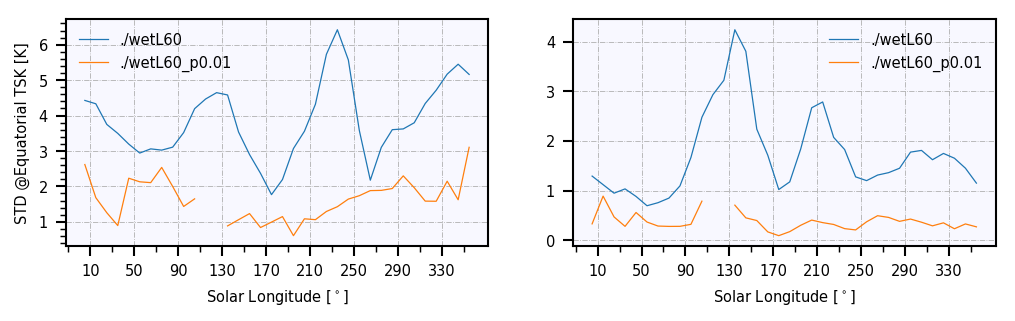

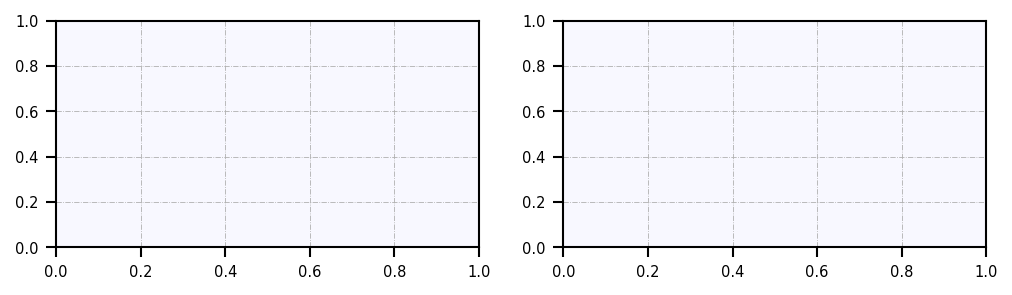

In [25]:
def yearlyVariation(rawdata, pertdata):
    filedir = rawdata
    data = Dataset(filedir,'r')
    ls = data.variables['LS'][:][669:]
    psfc = data.variables['PSFC'][:][669:]
    tsk = data.variables['TSK'][:][669:]
    t = data.variables['T50Pa'][:][669:]

    filedir = pertdata
    data = Dataset(filedir,'r')
    lsp = data.variables['LS'][:]#[:6690]
    psfcp = data.variables['PSFC'][:]
    tskp = data.variables['TSK'][:]
    tp = data.variables['T50Pa'][:]

    def meanSTD(ls, period, i, data):
        # indexes corresponding to certain period
        idx = np.where(abs(ls-(i*period+period/2))<period/2)[0]
    
        # indexes corresponding to another year 
        idx_year = np.where(np.diff(idx)>1)[0]
        tmp = []
        if idx_year.size == 0:
            tmp.append( data[idx].mean(axis=0) )
        for j in np.arange(idx_year.size):
            if j == 0:
                tmp.append( data[idx[0:idx_year[j]+1]].mean(axis=0) )
            if j == idx_year.size-1:
                tmp.append( data[idx[idx_year[j]+1:]].mean(axis=0) )
            else:
                tmp.append( data[idx[idx_year[j]+1:idx_year[j+1]+1]].mean(axis=0) )
#                 if i == 11: print (data[idx[idx_year[j]+1:idx_year[j+1]+1]].mean(axis=0), data[idx[idx_year[j]+1:idx_year[j+1]+1]].mean(axis=0).shape)
#         if i == 11: print (i,tmp[:])
        tmp = np.array(tmp)
#         if i == 11: print (i,tmp[:])
        return tmp.std(axis=0)[17:20].mean()

    period = 10
    ndata = int(360/period)
    vart = np.zeros((ndata,2)) # shape depending on the period
    varp = np.zeros((ndata,2)) # shape depending on the period
    vart50_stdzm = np.zeros((ndata,2)) # shape depending on the period

    for i in np.arange(ndata):
        test = meanSTD(ls, period, i, psfc)
        test2 = meanSTD(lsp, period, i, psfcp)
        varp[i] = [test,test2]

        test = meanSTD(ls, period, i, tsk)
        test2 = meanSTD(lsp, period, i, tskp)
        vart[i] = [test,test2]

    #     test = meanSTD(lsdust, period, i, tdust[:,17:20].mean(axis=2).mean(axis=1))
    #     test2 = meanSTD(lswet, period, i, twet[:,17:20].mean(axis=2).mean(axis=1))
    #     vart50_stdzm[i] = [test,test2]

    print (varp)

    major_ticks = np.arange(10,370,40)
    xaxis = np.arange(5,365,period)
    
    
    ### neeed to automatize the plotting using for loops
    def stdplot(xaxis, stdpressure, stdtsk, rawlabel, pertlabel, title):
        fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8,2), sharex=True)
        ax.plot(xaxis, stdpressure[:,0], label=rawlabel.replace('.nc',''))
        ax.plot(xaxis, stdpressure[:,1], label=pertlabel.replace('.nc',''))
        ax.set_xticks(major_ticks)
        ax.set_ylabel(title)
        ax.set_xlabel('Solar Longitude [$^\circ$]')
        ax.xaxis.set_minor_locator(AutoMinorLocator(2))
        ax.yaxis.set_minor_locator(AutoMinorLocator(5))
        ax.legend()
        
        ax2.plot(xaxis, stdtsk[:,0], label=rawlabel.replace('.nc',''))
        ax2.plot(xaxis, stdtsk[:,1], label=pertlabel.replace('.nc',''))
        ax.set_ylabel(title.replace('PSFC [Pa]', 'TSK [K]'))
        ax2.set_xlabel('Solar Longitude [$^\circ$]')
        ax2.legend()
    
    stdplot(xaxis, varp, vart, rawdata, pertdata, 'STD @Equatorial PSFC [Pa]')
#     stdplot(xaxis, vart[:,0], vart[:,1], rawdata, pertdata, 'STD @Equatorial TSK [K]')

yearlyVariation('./wetL60.nc', './wetL60_p0.01.nc')
yearlyVariation('./dustL45.nc', './dustL45_p0.01.nc')

In [ ]:
idx[0].reshape((10,40))

In [ ]:
def animatedDiff(old_data, new_data):
    import matplotlib.animation as animation
    FFwriter = animation.FFMpegWriter()
    
    fig = plt.figure()
    
    images = []
    for i in tqdm(np.arange(new_data.shape[0])[500:]):
        im = plt.contourf(np.linspace(-180,180,72), np.linspace(-90,90,36), np.abs(old_data[4800+i]-new_data[i]))
#         im = im.collections
        def setvisible(self,vis):
            for c in self.collections: c.set_visible(vis)
        def setanimated(self,ani):
            for c in self.collections: c.set_animated(ani)
                
        im.set_visible = types.MethodType(setvisible,im)
        im.set_animated = types.MethodType(setanimated,im)
        im.axes = plt.gca()
        im.figure=fig
    
#         plt.colorbar()
        images.append([im])
    
    ani = animation.ArtistAnimation(fig, images, interval=70, blit=False,repeat_delay=1000)
#     ani.save('basic_animation.mp4', writer = FFwriter)
    ani.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
    plt.show()
    

# dust data
filedir = './dustL45_test.nc'
data = Dataset(filedir,'r')
psfc = data.variables['TSK'][:]
t = data.variables['T50Pa'][:]
ls = data.variables['LS'][:]
ls = yearly_ls(ls)

# dust perturbation high res scale
filedir = './dustL45_p0.01.nc'
data = Dataset(filedir,'r')
psfcp = data.variables['TSK'][:]
tp = data.variables['T50Pa'][:]
lsp = data.variables['LS'][:]
lsp = yearly_ls(lsp) + 2880


idx = np.where(ls==lsp[0])[0][0]
idx2 = np.where(ls==lsp[-1])[0][0]

# figure(1)
# contourf(np.arange(psfcp.shape[0]), np.linspace(-180,180,72), np.sqrt(np.abs(psfc[idx:idx2+1,30]**2-psfcp[:,30]**2)).T)
# #xlim([0,50])
# colorbar()

figure(2)
contourf(np.linspace(-180,180,72), np.linspace(-90,90,36), (np.abs(psfc[4980]-psfcp[100])))
colorbar()

# animatedDiff(psfc, psfcp)


In [ ]:
fig = plt.figure()
import matplotlib.animation as animation
def animate(i): 
    if i%20 ==0: print (i)
    z = np.abs(t[4880+(i*5)] - tp[i*5]) 
    cont = plt.contourf(z, np.linspace(0,40,21))
    title('Sols {}'.format(i*5))
#     if (tslice == 0)
#         plt.title(r't = %1.2e' % t[i] )
#     else:
#         plt.title(r't = %i' % i)

    return cont
anim = animation.FuncAnimation(fig, animate, frames=120)
anim.save('animation.mp4')

In [ ]:
print (np.where(lsdust==lsdustp[0]))
print (np.where(lsdust==lsdustp[-1]))
print(psfcdust.shape)
print(psfcdustp.shape)